In [ ]:
!nvidia-smi

Wed Apr 21 22:26:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 "sec)"}'

0.0127211days (1099.10sec)


In [ ]:
!git clone https://github.com/yours-schnee/custom_ImageNet.git

Cloning into 'custom_ImageNet'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 57 (delta 19), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (57/57), done.


In [ ]:
!pip install -e ./custom_ImageNet

ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /content/custom_ImageNet


In [ ]:
import sys
sys.path.append('/content/custom_ImageNet')

import custom_ImageNet
from utils.ImageNetDataset import make_path_list
from utils.ImageNetDataset import str_convert
from utils.ImageNetDataset import ImageNetDataset

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import init
from torch.optim import lr_scheduler
from torch import optim

In [ ]:
import glob
import os
import time
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import classification_report
import statistics
import itertools
np.set_printoptions(threshold=np.inf)
#from PIL import Image  
import PIL
import PIL.Image
from PIL import ImageFile

#import copy
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data
import datetime

!pip install tensorboardX
import tensorboardX as tbx
from tensorboardX import SummaryWriter


     |████████████████████████████████| 122kB 9.8MB/s 


In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "drive/My Drive/ImageNet/retina_10random_ImagenetTrain.zip" /content/
!cp "drive/My Drive/ImageNet/retina_original_ImagenetTest.zip" /content/

In [ ]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [ ]:
!7z x retina_10random_ImagenetTrain.zip
!mv "content/retina_ImagenetTrain" ../content/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 2888291374 bytes (2755 MiB)

Extracting archive: retina_10random_ImagenetTrain.zip
  2% 4096 Open              --
Path = retina_10random_ImagenetTrain.zip
Type = zip
Physical Size = 2888291374
64-bit = +

  0%      0% 532 - content/retina_ImagenetTrain/pineapple/pineapple_6847.jpg                                                                      0% 916 - content/retina_ImagenetTrain/pineapple/pineapple_6511.jpg                                                                    

In [ ]:
!7z x retina_original_ImagenetTest.zip
!mv "content/retina_ImagenetTest" ../content/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 34489251 bytes (33 MiB)

Extracting archive: retina_original_ImagenetTest.zip
--
Path = retina_original_ImagenetTest.zip
Type = zip
Physical Size = 34489251

  0%     38% 797 - content/retina_ImagenetTest/elephant/elephant_040.jpg                                                                 77% 1572 - content/retina_ImagenetTest/bear/bear_084.jpg                                                         Everything is Ok

Folders: 21
Files: 2000
Size:       34552399
Comp

In [ ]:
import shutil

directory = 'content'

try:
    shutil.rmtree(directory)
except FileNotFoundError:
    pass

In [ ]:
rootpathTrain ='retina_ImagenetTrain/'
rootpathTest ='retina_ImagenetTest/'

# Get folder name
train_img_list = make_path_list(rootpathTrain)
test_img_list = make_path_list(rootpathTest)

In [ ]:
simple_transform = transforms.Compose([transforms.Resize((224,224),interpolation=3),
                                       transforms.ToTensor()])

train_dataset = ImageNetDataset(train_img_list, phase="train", transform=simple_transform)

test_dataset = ImageNetDataset(test_img_list, phase="test",
                          transform=simple_transform)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
np.random.seed(6)
device = torch.device("cuda" if use_cuda else "cpu")
#classes_list = train_dataset.get_label_relation()
classes_list = test_dataset.get_label_relation()

batch_size = 32

In [ ]:
# training data split to train and val
validation_split = .2

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

# Creating PT data samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [ ]:
# dataloder
trainloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)

valloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)

#trainloader = data.DataLoader(
#    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

dataloaders_dict = {"train": trainloader, "val": valloader}

In [ ]:
index_dict = {"train": train_idx, "val": valid_idx}
len(index_dict["train"])

141568

In [ ]:
"""cnt = 0
for epoch in range(2):
    for images, labels in tqdm(testloader):
        cnt += 1
        if (cnt%10)
        print()"""

'cnt = 0\nfor epoch in range(2):\n    for images, labels in tqdm(testloader):\n        cnt += 1\n        if (cnt%10)\n        print()'

--------------------
(224, 224, 3)


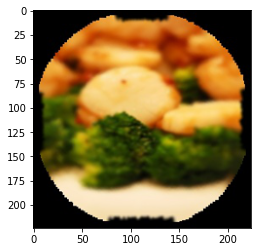

In [ ]:
index = 2
imges, label = test_dataset.__getitem__(index)

img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
print("--------------------")
print(img_val.shape)
plt.imshow(img_val)
plt.show()


In [ ]:
#code adapted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion(cm, classes, name, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    #print(cm)
    filename= name + "_confusion.png"
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/"
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.0f}".format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path+filename)


In [ ]:
def plot_graph(training_losses,val_losses,epochs,string,name):
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(string)

    filename = name + "_" + string + "_.png" 
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/{filename}"
    plt.title(string + 'per epoch - ' + "Simple classifier")
    
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.savefig(path+filename)
    print(path+filename)

In [ ]:
# This function will test mask image generation, not the difference between original and generated images
  
def test_model(model, criterion, name):

    model.eval()
    test_epoch_loss = 0
    test_correct = 0
    best_accuracy = 0
    class_correct = list(0 for i in range(N_CLASSES))
    class_total = list(0 for i in range(N_CLASSES))
    mean_accuracies = list(0 for i in range(n_iterations))
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    labelslist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad():
        accuracies = [[] for i in range(n_iterations)]
        #for index,(images, anno, labels) in enumerate(testloader):
        for index,(images, labels) in enumerate(testloader):
            images, labels = images.cuda(), labels.cuda()

            predicted = model(images)
            loss = criterion(predicted,labels)

            test_epoch_loss += loss.item()

            best_predicted = predicted
            _, predicted_l = torch.max(best_predicted.data, 1)
            test_correct += (predicted_l == labels).sum().item()
            c = (predicted_l == labels).squeeze()

            predlist=torch.cat([predlist,predicted_l.view(-1).cpu()])
            labelslist=torch.cat([labelslist,labels.view(-1).cpu()])

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    test_epoch_loss /= len(testloader)
    print('\nTest loss: {:.4f} \nTesting Accuracy: {}/{} ({:.2f}%)'.format(
          test_epoch_loss, test_correct, len(testloader.dataset),
          100. * test_correct / len(testloader.dataset)))
    for i in range(N_CLASSES):
        print("{} Class Accuracy: {}/{} ({:.2f}%)".format(classes_list[i],class_correct[i],class_total[i],100*class_correct[i]/class_total[i]))

    precision = precision_score(predlist.numpy(), labelslist.numpy(), average='macro')
    recall = recall_score(predlist.numpy(), labelslist.numpy(), average='macro')
    accuracy = accuracy_score(predlist.numpy(), labelslist.numpy())
    f1 = fbeta_score(predlist.numpy(), labelslist.numpy(), 1, average='macro') #1 means f_1 measure
    print("Classifier has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (accuracy,precision,recall,f1))
    conf_matrix=confusion_matrix(labelslist.numpy(), predlist.numpy())
    plt.figure(figsize=(8, 8))
    plot_confusion(conf_matrix, classes_list, name, 'Confusion matrix')
    print(classification_report(labelslist.numpy(), predlist.numpy(),target_names=classes_list))

    return mean_accuracies

### Loss function

In [ ]:
# Loss fuc setting
criterion = nn.CrossEntropyLoss()

### Training & Test for model

In [ ]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs, name, folder_name, debug_mode=False):
    
    log_path = F"/content/drive/My Drive/Colab Notebooks/Log/"
    now = datetime.datetime.now()
    folder = F"{name}"+now.strftime('%Y%m%d_%H%M%S')

    writer = tbx.SummaryWriter(log_path+folder)

    global best_accuracy;
    global training_losses; global val_losses;
    global train_accuracies; global val_accuracies;
    global epochs;
    global stats;
    train_loss=0; val_loss=0; train_acc=0; val_acc=0; 
    for epoch in range(epochs,num_epochs):
        epoch = epoch + 1
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')

        # loop for training and validation every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # training mode
            else:
                model.eval()    # validation mode

            epoch_loss = 0.0    # epoch loss
            epoch_acc = 0       # epoch correct

            #for images, anno, labels in tqdm(dataloaders_dict[phase]):
            for images, labels in tqdm(dataloaders_dict[phase]):
                #images, anno, labels = images.cuda(), anno.cuda(), labels.cuda()
                images, labels = images.cuda(), labels.cuda()
      
                # initialize optimizer
                optimizer.zero_grad()

                # feedforward calc
                with torch.set_grad_enabled(phase == 'train'):
                    predicted = model(images)
                    loss = criterion(predicted, labels)       # loss calc
                    preds = predicted.max(1,keepdim=True)[1]  # label preds

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # calc of iter results
                    epoch_loss += loss.item()
                    epoch_acc += preds.eq(labels.view_as(preds)).sum().item()

            #print(epoch_acc)
            epoch_loss = epoch_loss / len(index_dict[phase])
            epoch_acc = epoch_acc / len(index_dict[phase]) *100.
            
            # stats data save
            if phase == 'train':
                training_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
                train_loss=epoch_loss; train_acc=epoch_acc;
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                val_loss=epoch_loss; val_acc=epoch_acc;

                # best model save
                if (epoch_acc > best_accuracy) and debug_mode==False:
                    best_accuracy = epoch_acc
                    best_model = deepcopy(model)
                    
                    total_name = name+".tar"
                    path = F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{total_name}"
                    torch.save({"best_model":model.state_dict(),
                                "best_acc":best_accuracy
                                },path)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if epoch%4==0:
            # Colab's disconnection timing while saving data might cause the broken save data against our hope.
            # So, results every epochs will be saved every epochs.
            
            total_name = name+"_epoch"+str(epoch)+".tar"

            path = F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{total_name}"
            torch.save({
                "epoch":epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss":training_losses,
                "val_loss":val_losses,
                "train_acc":train_accuracies,
                "val_acc":val_accuracies
                }, path)
            
        print('-------------')
        writer.add_scalars('/loss', {'train_loss': train_loss,
                                     'val_loss': val_loss
                                    }, epoch)
      
        writer.add_scalars('/acc', {'train_acc': train_acc,
                                    'val_acc': val_acc
                                    }, epoch)

    print("Lowest training loss", min(training_losses))
    print("Lowest validation loss", min(val_losses))
    print("Highest training accuracy",max(train_accuracies))
    print("Highest validation accuracy",max(val_accuracies))
    print('-------------')

    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

    return best_model, stats

### VGG16 fine tuning

In [ ]:
# Load pre-trained VGG-16
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

N_CLASSES = 20

# Replacement last layer output for 20 classes
net.classifier[6] = nn.Linear(in_features=4096, out_features=N_CLASSES)

net.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Store parameters through transfer learning, which are re-trained
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# Re-trained params
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# Non re-trained params keep their grads
for name, param in net.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1 stores：", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2 stores：", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3 stores：", name)

    else:
        param.requires_grad = False
        print("Freazed：", name)

params_to_update_1 stores： features.0.weight
params_to_update_1 stores： features.0.bias
params_to_update_1 stores： features.2.weight
params_to_update_1 stores： features.2.bias
params_to_update_1 stores： features.5.weight
params_to_update_1 stores： features.5.bias
params_to_update_1 stores： features.7.weight
params_to_update_1 stores： features.7.bias
params_to_update_1 stores： features.10.weight
params_to_update_1 stores： features.10.bias
params_to_update_1 stores： features.12.weight
params_to_update_1 stores： features.12.bias
params_to_update_1 stores： features.14.weight
params_to_update_1 stores： features.14.bias
params_to_update_1 stores： features.17.weight
params_to_update_1 stores： features.17.bias
params_to_update_1 stores： features.19.weight
params_to_update_1 stores： features.19.bias
params_to_update_1 stores： features.21.weight
params_to_update_1 stores： features.21.bias
params_to_update_1 stores： features.24.weight
params_to_update_1 stores： features.24.bias
params_to_update_1

In [ ]:
vgg_optimizer2 = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)

In [ ]:
# Optimization setting
#vgg_optimizer2 = optim.SGD(net.parameters(), lr=0.007, momentum=0.9)

### CONST data

In [ ]:
# for FC layer's input size computation
img_shapes = [224, 224]

DEBUG = False
if DEBUG:
    NUM_EPOCS = 14
else:
    NUM_EPOCS = 30

n_iterations = 50
N_CLASSES = 20
FC_H = img_shapes[0]//2**4 # 4 is max plling layer num
FC_W = img_shapes[1]//2**4

In [ ]:
LOAD_STATE = False
EPOCH = 16             # This values need to check the latest tar ffile name with epoch.
name = "05_VGG_fine_tunedoptim"
folder_name = "VGG_fine"

if LOAD_STATE:
    stats=[];
    
    PATH1 =  F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{name}.tar"

    checkpoint = torch.load(PATH1)
    best_model = net
    best_model.load_state_dict( checkpoint["best_model"] )
    best_accuracy = 0#checkpoint["best_acc"]

    # Colab's disconnection timing while saving data might cause the broken save data against our hope.
    # So, results every epochs will be saved every epochs.
    total_name = name+"_epoch"+str(EPOCH)+".tar"
    PATH2 =  F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{total_name}"

    checkpoint = torch.load(PATH2)
    epochs = checkpoint["epoch"]
    net.load_state_dict( checkpoint["model_state_dict"] )
    vgg_optimizer2.load_state_dict( checkpoint["optimizer_state_dict"] )
    training_losses = checkpoint["train_loss"]; val_losses = checkpoint["val_loss"];
    train_accuracies = checkpoint["train_acc"]; val_accuracies = checkpoint["val_acc"];
    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

else:
    # start point
    best_model=net;
    best_accuracy = 0;
    training_losses = []; val_losses = [];
    train_accuracies = []; val_accuracies = [];
    stats=[];
    epochs=0;


In [ ]:
best_vgg2, stats_vgg2 = train_model(net, dataloaders_dict, criterion, vgg_optimizer2, NUM_EPOCS, name, folder_name, DEBUG)

Epoch 1/40
-------------



train Loss: 0.0266 Acc: 72.4359



val Loss: 0.0188 Acc: 80.4560
-------------
Epoch 2/40
-------------



train Loss: 0.0175 Acc: 81.6738



val Loss: 0.0153 Acc: 84.1235
-------------
Epoch 3/40
-------------



train Loss: 0.0136 Acc: 85.6288



val Loss: 0.0133 Acc: 85.9403
-------------
Epoch 4/40
-------------



train Loss: 0.0107 Acc: 88.5800



val Loss: 0.0117 Acc: 87.8419
-------------
Epoch 5/40
-------------



train Loss: 0.0084 Acc: 91.0841



val Loss: 0.0107 Acc: 88.9410
-------------
Epoch 6/40
-------------



train Loss: 0.0064 Acc: 93.1072



val Loss: 0.0097 Acc: 90.1023
-------------
Epoch 7/40
-------------



train Loss: 0.0048 Acc: 94.7863



val Loss: 0.0099 Acc: 90.4470
-------------
Epoch 8/40
-------------



train Loss: 0.0036 Acc: 96.0860



val Loss: 0.0094 Acc: 91.1308
-------------
Epoch 9/40
-------------



train Loss: 0.0028 Acc: 97.0488



val Loss: 0.0094 Acc: 91.5179
-------------
Epoch 10/40
-------------



train Loss: 0.0022 Acc: 97.6541



val Loss: 0.0095 Acc: 91.7863
-------------
Epoch 11/40
-------------



train Loss: 0.0017 Acc: 98.1408



val Loss: 0.0095 Acc: 91.8287
-------------
Epoch 12/40
-------------



train Loss: 0.0014 Acc: 98.5117



val Loss: 0.0096 Acc: 92.2045
-------------
Epoch 13/40
-------------



train Loss: 0.0012 Acc: 98.7857



val Loss: 0.0098 Acc: 92.4418
-------------
Epoch 14/40
-------------



train Loss: 0.0009 Acc: 99.0068



val Loss: 0.0098 Acc: 92.6509
-------------
Epoch 15/40
-------------



train Loss: 0.0008 Acc: 99.1163



val Loss: 0.0098 Acc: 92.6791
-------------
Epoch 16/40
-------------



train Loss: 0.0007 Acc: 99.2760



val Loss: 0.0103 Acc: 92.5181
-------------
Epoch 17/40
-------------



train Loss: 0.0007 Acc: 99.3127



val Loss: 0.0098 Acc: 92.8119
-------------
Epoch 18/40
-------------



train Loss: 0.0005 Acc: 99.4519



val Loss: 0.0111 Acc: 92.3909
-------------
Epoch 19/40
-------------



train Loss: 0.0005 Acc: 99.4377



val Loss: 0.0105 Acc: 92.5181
-------------
Epoch 20/40
-------------



train Loss: 0.0005 Acc: 99.5218



val Loss: 0.0103 Acc: 92.9108
-------------
Epoch 21/40
-------------



train Loss: 0.0004 Acc: 99.5917



val Loss: 0.0108 Acc: 92.6933
-------------
Epoch 22/40
-------------



train Loss: 0.0004 Acc: 99.5882



val Loss: 0.0108 Acc: 92.7187
-------------
Epoch 23/40
-------------



train Loss: 0.0003 Acc: 99.6708



val Loss: 0.0108 Acc: 92.9419
-------------
Epoch 24/40
-------------



train Loss: 0.0003 Acc: 99.6631



val Loss: 0.0112 Acc: 92.6000
-------------
Epoch 25/40
-------------



train Loss: 0.0003 Acc: 99.6595



val Loss: 0.0107 Acc: 92.9645
-------------
Epoch 26/40
-------------



train Loss: 0.0003 Acc: 99.6744



val Loss: 0.0109 Acc: 92.9391
-------------
Epoch 27/40
-------------



train Loss: 0.0003 Acc: 99.7288



val Loss: 0.0115 Acc: 92.8232
-------------
Epoch 28/40
-------------



train Loss: 0.0003 Acc: 99.7330



val Loss: 0.0106 Acc: 93.3092
-------------
Epoch 29/40
-------------



train Loss: 0.0002 Acc: 99.7535



val Loss: 0.0107 Acc: 93.3262
-------------
Epoch 30/40
-------------



train Loss: 0.0002 Acc: 99.7761



val Loss: 0.0114 Acc: 93.0606
-------------
Epoch 31/40
-------------



train Loss: 0.0002 Acc: 99.7591



val Loss: 0.0107 Acc: 93.2527
-------------
Epoch 32/40
-------------



train Loss: 0.0002 Acc: 99.7909



val Loss: 0.0115 Acc: 93.0351
-------------
Epoch 33/40
-------------



train Loss: 0.0002 Acc: 99.8291



val Loss: 0.0112 Acc: 93.2442
-------------
Epoch 34/40
-------------



train Loss: 0.0002 Acc: 99.7916



val Loss: 0.0110 Acc: 93.2923
-------------
Epoch 35/40
-------------



train Loss: 0.0002 Acc: 99.8227



val Loss: 0.0122 Acc: 92.8543
-------------
Epoch 36/40
-------------



train Loss: 0.0002 Acc: 99.8382



val Loss: 0.0108 Acc: 93.5014
-------------
Epoch 37/40
-------------



train Loss: 0.0001 Acc: 99.8870



val Loss: 0.0112 Acc: 93.4957
-------------
Epoch 38/40
-------------



train Loss: 0.0002 Acc: 99.8093



val Loss: 0.0109 Acc: 93.1877
-------------
Epoch 39/40
-------------



train Loss: 0.0002 Acc: 99.8382



val Loss: 0.0110 Acc: 93.5748
-------------
Epoch 40/40
-------------



train Loss: 0.0002 Acc: 99.8630



val Loss: 0.0111 Acc: 93.2923
-------------
Lowest training loss 0.00012164314768228873
Lowest validation loss 0.009437924574743753
Highest training accuracy 99.88698010849909
Highest validation accuracy 93.57481916817359
-------------


/content/drive/My Drive/Colab Notebooks/Graphs/05_VGG_fine_tunedoptim_Loss _.png05_VGG_fine_tunedoptim_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/05_VGG_fine_tunedoptim_Accuracy _.png05_VGG_fine_tunedoptim_Accuracy _.png


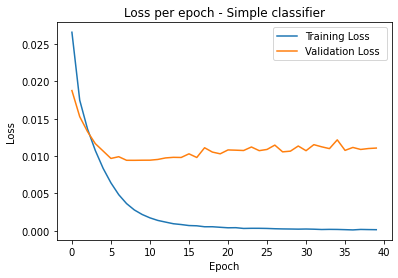

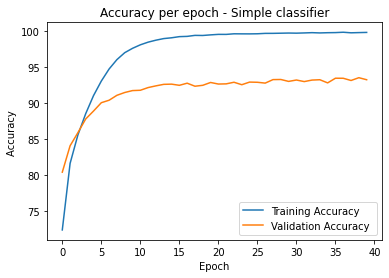

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats_vgg2[0],stats_vgg2[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats_vgg2[1],stats_vgg2[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 1.1747 
Testing Accuracy: 1702/2000 (85.10%)
apple Class Accuracy: 72/100 (72.00%)
banana Class Accuracy: 87/100 (87.00%)
bear Class Accuracy: 91/100 (91.00%)
bell_pepper Class Accuracy: 83/100 (83.00%)
bird Class Accuracy: 85/100 (85.00%)
broccoli Class Accuracy: 76/100 (76.00%)
cat Class Accuracy: 79/100 (79.00%)
cauliflower Class Accuracy: 85/100 (85.00%)
cow Class Accuracy: 93/100 (93.00%)
dog Class Accuracy: 85/100 (85.00%)
elephant Class Accuracy: 98/100 (98.00%)
fox Class Accuracy: 96/100 (96.00%)
goat Class Accuracy: 76/100 (76.00%)
horse Class Accuracy: 82/100 (82.00%)
mashed_potato Class Accuracy: 89/100 (89.00%)
orange Class Accuracy: 81/100 (81.00%)
pineapple Class Accuracy: 86/100 (86.00%)
pomegranate Class Accuracy: 82/100 (82.00%)
tomato Class Accuracy: 82/100 (82.00%)
zebra Class Accuracy: 94/100 (94.00%)
Classifier has Acc=0.851 P=0.851 R=0.854 F1=0.851
               precision    recall  f1-score   support

        apple       0.80      0.72      0.76     

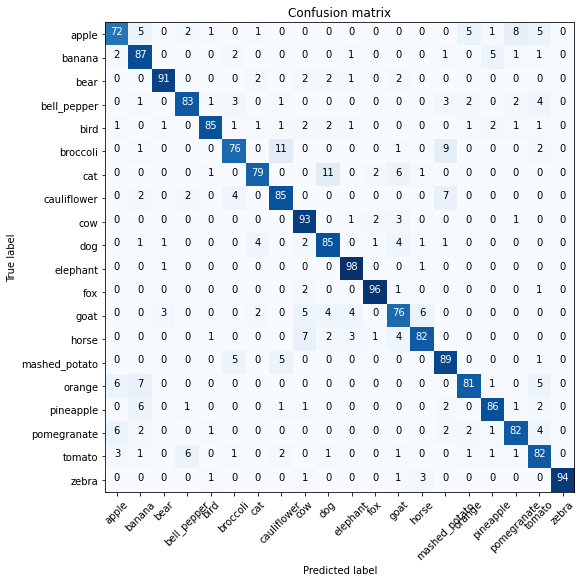

In [ ]:
result = test_model(best_vgg2,criterion, name)